# Ocotillo Valley

In [1]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import flopy
import flopy.utils.binaryfile as bf
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter

## Pre-process GIS files to convert them into MODFLOW-friendly csv files ##

0
1


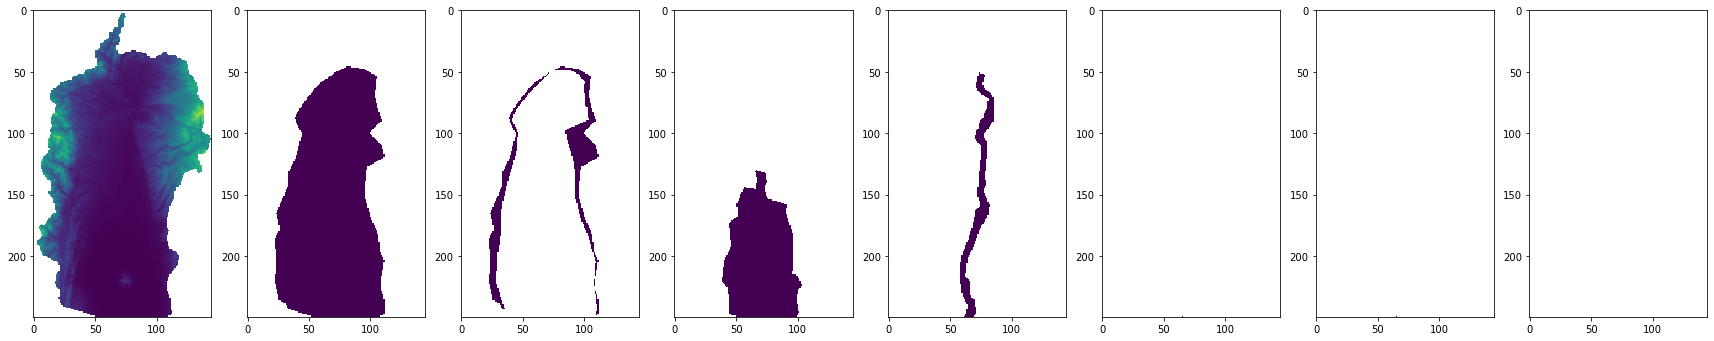

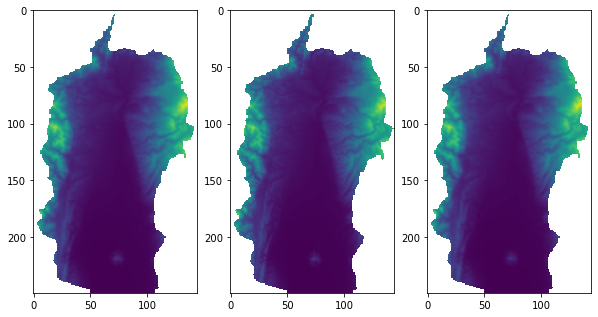

In [321]:
run = True    #to run this section, set to True
if run:         #if run is True, run the section
    
    #Clip text file extent and convert to csv:
    files = ['dem','valley','recharge','ag','riparian','stream','stage','wells']
    fig,ax = plt.subplots(1,len(files), figsize=(30,10))
    for i,f in enumerate(files):
        a = np.asarray(pd.read_csv(f+'1000.txt', header=None, skiprows=6, delimiter=' ', na_values=-9999))
        #print(np.shape(a))
        a = a[65:315,110:255]
        #print(np.shape(a))
        if f == 'recharge':
            a[a>0] = 1
        if f == 'dem':
            a = a + 600
        ax[i].imshow(a)
        np.savetxt(f+'.csv', a, delimiter=',')
        
    #Make a smoother version of topography to avoid convergence errors
    n = 2
    fig,ax = plt.subplots(1,n+1,figsize=(10,10))
    ax[0].imshow(topo)
    for i in range(n):
        print(i)
        topo = np.genfromtxt('dem.csv', delimiter=',')   #load the model topography from a csv file. It will then be used to define the model grid.
        w = 2
        smooth = np.full((nrow,ncol),500.)
        for row in range(nrow):
            for col in range(ncol):
                z = topo[row,col]
                try:
                    zavg = np.mean(topo[row-w:row+w,col-w,row+w])
                except:
                    try:
                        zavg = np.mean(topo[row-w:row,col-w,col])
                    except:
                        try:
                            zavg = np.mean(topo[row:row+w,col:col+w])
                        except:
                            print('averaging error')
                smooth[row,col] = zavg
        np.savetxt('dem.csv', smooth, delimiter=',')   #overwrite with new smoothed dem
        ax[i+1].imshow(smooth)

## Model set up ##

In [336]:
##Name:
modelname = "ocotillo"

##Units:
itmuni = 5                        #time unit: 1:sec, 2:min, 3:hr, 4:day, 5:year
lenuni = 2                        #length unit: 1:ft, 2:meters

##Grid:
topo = np.genfromtxt('dem.csv', delimiter=',')   #load the model topography from a csv file. It will then be used to define the model grid.
nrow = np.shape(topo)[0]          #number of rows
ncol = np.shape(topo)[1]          #number of columns
delr = 1000.                      #width of each cell along rows (so really this is column width along x axis)
delc = 1000.                      #width of each cell along columns (so really this is row height along y axis)
Lx = ncol*delr                    #width of domain in x (across columns) = number of columns x cell width
Ly = nrow*delc                    #width of domain in y (across rows) = number of rows x cell height

##Layers:
#IMPORTANT: MODFLOW doesn't like thin low-K layers. To add a low-K layer to act as a confining unit,
#you MUST use something called a Quasi-3D confining bed. So, the number of layers in the model will be 1 less than the actual number of layers you want.
#Define which layer the confining bed goes below in laycbd. Define its thickness by adding a layer to botm.

nlay = 2                                    #number of layers 
layers = np.arange(nlay)                    #make array of layers
ztop = topo.copy()                          #make a copy of the topo array to use for MODFLOW
ztop[np.isnan(ztop)] = np.nanmean(ztop)     #replace nan values with mean elevation (mostly for plotting)
zbot = 0.                                #set bottom elevation of model (datum)
botm = np.full((nlay+1,nrow,ncol),zbot)     #make array of default cell bottom elevations for each cell in the model (dim:nlay,nrow,ncol)
botm[0,:,:] = zbot+400                      #for the top layer, set the bottom elevation 
botm[1,:,:] = zbot+350                      #for the quasi-3d confining layer, set the bottom elevation
laytyp = [0,0]                              #whether each layer is confined or unconfined. 0:confined, 1: unconfined
laycbd = [1,0]                              #whether each layer has a confining unit below it. 0: no, 1: yes

##Medium properties:
#Hydraulic conductivity:
#Kx and Ky:
Kx = np.full((nlay,nrow,ncol),112)         #create array of default horizontal hydraulic conductivity (along rows)
Kx[0,40:nrow,60:90] = 164                  #set Kx in top layer, along a north-south strip, to be higher (represents high-K alluvial sediments)
Kx[1,:,:] = 90                             #set Kx in bottom layer to be lower (represents more compacted sediment)
K_ratio = 1                                #ratio of Ky/Kx (aka Kcol/Krow) - if Kx=Ky, ratio=1
#Kz:
Kz = np.full((nlay,nrow,ncol),13.7)        #create array of default vertical hydraulic conductivity (between layers, along z axis)
Kz[0,40:nrow,60:90] = 16.2                 #set Kz in top layer, along a north-south strip, to be higher (represents high-K alluvial sediments)
Kz[1,:,:] = 9.4                            #set Kz in bottom layer to be lower (represents more consolidated sediment)
Kzc = 3.25e-4                              #set Kz for confining layer

#Porosity, storage, specific yield, confined/unconfined:
n  = 0.3              #porosity
Ss = 0.0001           #storage coefficient (water released from compaction)
Sy = 0.1              #specific yield (water released from desaturation)

In [337]:
##Constant head boundary conditions:
#if ibound < 0, constant head; if ibound = 0, inactive/no-flow/outside of watershed; if ibound > 0, active.

#create arrays to indicate active cells and boundary conditions (ibound):
ibound = np.full((nlay,nrow,ncol),0)                            #make array of zeros for default boundary conditions (dim:nlay,nrow,ncol)
ibound[:,:,:] =  np.genfromtxt('valley.csv', delimiter=',')     #import locations of active and inactive cells from csv (all layers, all rows, all cols)
ibound[ibound!=1] = 0                                           #set all inactive cells equal to zero
ibound[:,nrow-1,:] = -1                                         #replace southernmost row (slice all layers, active rows, last column) with -1 to indicate constant head

#create array of initial head values across the model and at the boundaries
#hstart = np.genfromtxt('hstart.csv', delimiter=',')    #load starting hydraulic head map from csv file
#hstart[hstart<zbot] = 0                                #set no-flow cells to zero
strt = np.full((nlay, nrow, ncol), zbot+500)            #make array of initial head in all cells 
#strt[1,:,:] = strt[0,:,:]-25                           #set initial head in bottom layer to be lower

In [368]:
## Recharge
rech = np.genfromtxt('recharge.csv', delimiter=',')  #load csv file with recharge zones (1=recharge zone, nan=no recharge)
rech[np.isnan(rech)] = 0                             #set nan values to 0 so MODFLOW doesn't panic
rech[rech==1] = 1.15                               #set recharge rate in recharge zone

In [369]:
##Wells:
#Pumping rate is positive if injecting, negative if extracting

well_loc = [0,150,65]         #well location: [lay, row, col]
Qwell = -5e5                  #well pumping rate 
well_loc2 = [1,175,65]        #add a second well location
Qwell2 = -5e5                 #second well pumping rate
well_info = [[well_loc[0],well_loc[1],well_loc[2], Qwell],
             [well_loc2[0],well_loc2[1],well_loc2[2], Qwell2]
            ]                 #well info: [lay, row, col, pumping rate] , one entry per well

well_spd = {0: well_info}     #create a dictionary with entries for each stress period

In [370]:
##Sections that rarely change:

##Outputs: we are telling the model which outputs to print
oc_spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...']
ipakcb = 53    #unit to save cell-by-cell outputs to

#Create the model objects and the objects for each package
#Note: running this section multiple times without changing filenames (see block above) will overwrite the existing 
#files & generate a warning that existing packages are being replaced. This is fine.

#Create model object:
mf = flopy.modflow.Modflow(modelname, exe_name='mf2005')    #MODFLOW executable must be in same folder, named mf2005.exe
    
#Create objects for each package (see GHW1 notebook for details):
dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, delr=delr, delc=delc, top=ztop, botm=botm, 
                               laycbd=laycbd, itmuni=itmuni, lenuni=lenuni)         #DIS (Discretization): creates model grid   
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)           #BAS (Basic): assigns head boundaries
lpf = flopy.modflow.ModflowLpf(mf, laytyp=laytyp, chani=0, hk=Kx, hani=K_ratio, vka=Kz, vkcb=Kzc,
        ss=Ss, sy=Sy, storagecoefficient=False, ipakcb=ipakcb)            #LPF (Layer Property Flow): assigns flow props between cells
oc = flopy.modflow.ModflowOc(mf, stress_period_data=oc_spd, compact=True) #OC (Output Control): Decides what outputs to save
pcg = flopy.modflow.ModflowPcg(mf, hclose=1e-4, damp=0.5)                                        #PCG (Preconditioned Conjugate Gradient)
rch = flopy.modflow.mfrch.ModflowRch(mf, rech=rech)                       #RCH (Recharge)
#strm = flopy.modflow.mfstr.ModflowStr(mf, mxacts=nreach, nss=nseg, ntrib=0, ndiv=0,icalc=icalc, const=const, ipakcb=ipakcb,  istcb2=istcb2, dtype=None,
#        stress_period_data=str_spd, segment_data=str_segd, extension='str')  #STR (Stream)
#evt = flopy.modflow.mfevt.ModflowEvt(mf, surf=ztop, evtr=ET, exdp=extinction_depth, ipakcb=53)  #EVT (Evapotranspiration) - note: your computer may try to read this as an event log file
wel = flopy.modflow.mfwel.ModflowWel(mf, stress_period_data=well_spd)     #WEL (Well)  

## Display summary of model inputs ##

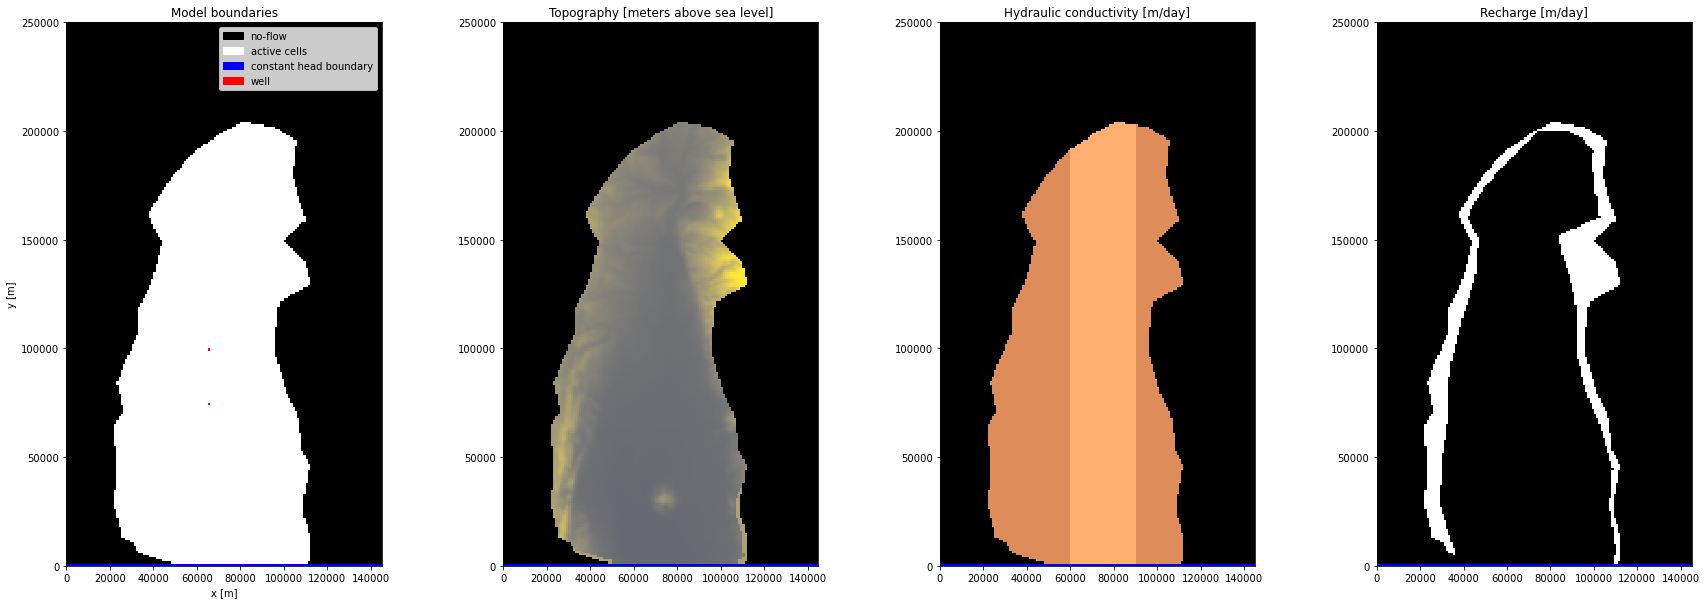

In [371]:
#Plot model boundaries and hydraulic properties:
f,ax = plt.subplots(1,4,figsize=(30,10))                    #create new figure and axes with subplots
ax[0].set_aspect('equal')
ax[0].set_title('Model boundaries')      #set first subplot title
m = flopy.plot.PlotMapView(model=mf, ax=ax[0], layer=0)     #create model map object on first subplot axes
#grid = m.plot_grid(colors='gray')                           #plot model grid
bc = m.plot_ibound()                                         #plot boundary conditions
w = m.plot_bc("WEL", color='red', plotAll=True)                           #plot wells
ax[0].set_xlabel('x [m]')
ax[0].set_ylabel('y [m]')
ax[0].legend(handles=[matplotlib.patches.Patch(color='black',label='no-flow'),      #add legend manually
                      matplotlib.patches.Patch(color='white',label='active cells'),
                      matplotlib.patches.Patch(color='blue',label='constant head boundary'),
                   # matplotlib.patches.Patch(color='skyblue', label='stream'),
                      matplotlib.patches.Patch(color='red', label='well')
                    ])

ax[1].set_title('Topography [meters above sea level]')      #set first subplot title
ax[1].set_aspect('equal')
m = flopy.plot.PlotMapView(model=mf, ax=ax[1], layer=0)     #create model map object on first subplot axes
t = m.plot_array(ztop, cmap='cividis', vmin=0, vmax=1500)   #plot topography array
bc = m.plot_ibound()                                        #plot boundary conditions

m = flopy.plot.PlotMapView(model=mf, ax=ax[2], layer=0)     #create model map object on second subplot axes
ax[2].set_aspect('equal')
ax[2].set_title('Hydraulic conductivity [m/day]')           #set first subplot title
k = m.plot_array(Kx, cmap='copper', vmin=-100, vmax=200)    #plot array of horizontal hydraulic conductivities (set range manually to control colors)
bc = m.plot_ibound()                                        #plot boundary conditions

m = flopy.plot.PlotMapView(model=mf, ax=ax[3], layer=0)     #create model map object on second subplot axes
ax[3].set_aspect('equal')
ax[3].set_title('Recharge [m/day]')                         #set first subplot title
k = m.plot_array(rech, cmap='bone')                         #plot array of horizontal hydraulic conductivities (set range manually to control colors)
bc = m.plot_ibound()                                        #plot boundary conditions

In [ ]:
#Plot cross-section view of model:
row = 200
col = 65

#South-North:
f,ax = plt.subplots(1,2, figsize=(25,5))                                     #create empty figure and axes objects
xsec= flopy.plot.PlotCrossSection(model=mf, ax=ax[0], line={'column': col})   #plot cross-section along given column (change column # to see different locations)
k  = xsec.plot_array(Kx, cmap='copper', vmin=-100, vmax=200)                #plot horizontal K as an array, with color range set manually to be consistent with other plots
ax[0].plot(np.arange(delr/2,Ly,delr), strt[0,:,col])                            #plots starting heads as a line
ax[0].plot(np.arange(delr/2,Ly,delr), strt[1,:,col], color='blue')                            #plots starting heads as a line
bc = xsec.plot_ibound()                                                      #plot boundary conditions
w = xsec.plot_bc("WEL", color='red')                           #plot wells
g  = xsec.plot_grid()                                                        #plot model grid
ax[0].set_xlabel('y [m]')
ax[0].set_ylabel('z [m]')
ax[0].set_title('north-south cross-section')

#East-West:
xsec= flopy.plot.PlotCrossSection(model=mf, ax=ax[1], line={'Row': row})    #plot cross-ection along stream row
k  = xsec.plot_array(Kx, cmap='copper', vmin=-100, vmax=200)                #plot heads as an array, with color range set manually to be consistent with other plots
ax[1].plot(np.arange(delc/2,Lx,delc), strt[0,row,:])                            #plots starting heads as a line
ax[1].plot(np.arange(delc/2,Lx,delc), strt[1,row,:], color='blue')                            #plots starting heads as a line
bc = xsec.plot_ibound()                                                     #plot boundary conditions
w = xsec.plot_bc("WEL", color='red')                           #plot wells
g  = xsec.plot_grid()                                                       #plot grid
ax[1].set_xlabel('x [m]')
ax[1].set_ylabel('z [m]')
ax[1].set_title('east-west cross-section')

plt.legend(handles=[matplotlib.patches.Patch(color='k',label='no-flow'),
                    matplotlib.patches.Patch(color='peru',label='Kx'),
                    matplotlib.lines.Line2D([],[], color='teal',label='head layer 0'),
                    matplotlib.lines.Line2D([],[], color='blue',label='head layer 1')]) #add legend manually

## Run model ##
The code in this section will change very little

In [ ]:
#Write MODFLOW input files:
mf.write_input()

#Run MODFLOW:
success, buff = mf.run_model()   #you should see "normal termination of simulation" printed below

## Get & view outputs ##

In [348]:
##Get outputs from binary output files:
#This section usually does not change much

#Get MODFLOW outputs:
hds = bf.HeadFile(modelname+'.hds')    #reads the raw binary head output file 
times = hds.get_times()                #returns a list of timesteps
head = hds.get_data(totim=times[-1])   #returns an array of heads for the specified time (last timestep)
head_mx = ma.masked_where(head<zbot, head)  #make a masked head array where all no-flow cells (with heads below the model bottom) are hidden

#Get cell-by-cell outputs from the cell budget output file:
#string options are in the list file under output control (make sure to include spaces!)
cbb = bf.CellBudgetFile(modelname+'.cbc')   #reads the cell budget file    
kstpkper_list = cbb.get_kstpkper()          #returns a list of stress periods & timesteps
frf = cbb.get_data(text='FLOW RIGHT FACE', totim=times[-1])[0]      #returns an array of flow rates for right face of cells
fff = cbb.get_data(text='FLOW FRONT FACE', totim=times[-1])[0]      #returns an array of flow rates for front face of cells

In [362]:
#Calculate some basic stats about hydraulic head distribution:

print('General hydraulic head info:')
hmin = np.min(head_mx)                  #get min, max, mean of entire model
hmax = np.max(head_mx)
hmean = np.mean(head_mx)
print('max head total:\t',hmax,'m \tmin head total:\t',hmin,'m \tmean head total:',hmean,'m')

hmin0 = np.min(head_mx[0,:,:])          #get min,max,mean of just top layer
hmax0 = np.max(head_mx[0,:,:])
hmean0 = np.mean(head_mx[0,:,:])
print('max head lay 0:\t',hmax0,'m \tmin head lay 0:\t',hmin0,'m \tmean head:',hmean0,'m')

hmin1 = np.min(head_mx[1,:,:])          #get min,max,mean of bottom layer
hmax1 = np.max(head_mx[1,:,:])
hmean1 = np.mean(head_mx[1,:,:])
print('max head lay 1:\t',hmax,'m \tmin head lay 1:\t',hmin,'m \tmean head:',hmean1,'m\n')

#Get head at specific location:
print('Hydraulic head a specific location')
lay = 0;  row = 100;  col = 50                                               #choose which cell to look at
print('head at lay',lay,'row', row, 'col', col,':', head[lay,row,col], 'm')  #get & print heads in that cell

General hydraulic head info:
max head total:	 521.85596 m 	min head total:	 490.69342 m 	mean head total: 508.50834086327933 m
max head lay 0:	 521.85596 m 	min head lay 0:	 500.0 m 	mean head: 511.73552512685063 m
max head lay 1:	 521.85596 m 	min head lay 1:	 490.69342 m 	mean head: 505.2811218461111 m

Hydraulic head a specific location
head at lay 0 row 100 col 50 : 518.4627 m


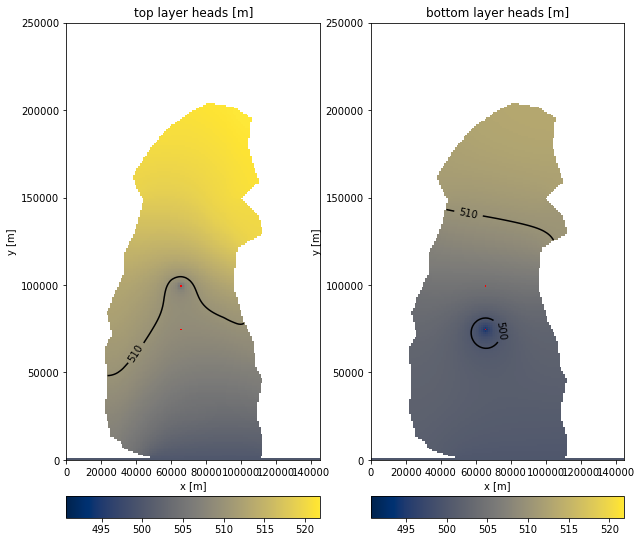

In [367]:
#Plot the hydraulic heads in each layer at the end of the model run
f,ax = plt.subplots(1,2, figsize=(10,10))         #create figure and axis objects

ax[0].set_title('top layer heads [m]')            #set figure title
ax[0].set_aspect('equal')                         #set aspect ratio equal to avoid stretching the map
maps = flopy.plot.PlotMapView(model=mf, ax=ax[0]) #create flopy map object
h = maps.plot_array(head_mx[0,:,:], cmap='cividis', vmin=hmin,vmax=hmax)  #plot heads as color map
levels = np.arange(hmin.round(-1), hmax.round(-1), 10)      #set contour range and interval (round to nearest 10)
c = maps.contour_array(head[0,:,:], masked_values=[-999.99], levels=levels, colors='k') #plot head contours
plt.clabel(c, rightside_up=False)   #add contour labels, not oriented up on the page but topographically up  
w = maps.plot_bc("WEL", color='red',plotAll=True)                         #plot wells (in all layers)
ax[0].set_xlabel('x [m]')
ax[0].set_ylabel('y [m]')
divider = make_axes_locatable(ax[0])                      #make axes dividable (to add colorbar)
cax = divider.append_axes('bottom', size="5%", pad=0.5)   #add an axis at the bottom for the colorbar
plt.colorbar(h, cax=cax, orientation='horizontal')        #plot the colorbar

ax[1].set_title('bottom layer heads [m]')                 #set figure title
ax[1].set_aspect('equal')                                 #set aspect ratio
maps = flopy.plot.PlotMapView(model=mf, ax=ax[1])         #create flopy map object
h = maps.plot_array(head_mx[1,:,:], cmap='cividis', vmin=hmin,vmax=hmax)  #plot heads as grayscale map
levels = np.arange(hmin.round(-1),hmax.round(-1), 10)                      #set contour range and interval
c = maps.contour_array(head[1,:,:], masked_values=[-999.99], levels=levels, colors='k') #plot head contours
plt.clabel(c, rightside_up=False)   #add contour labels, not oriented for reading but for contour direction  
w = maps.plot_bc("WEL", color='red', plotAll=True)                        #plot wells
ax[1].set_xlabel('x [m]')
ax[1].set_ylabel('y [m]')
divider = make_axes_locatable(ax[1])                      #make axes dividable (to add colorbar)
cax = divider.append_axes('bottom', size="5%", pad=0.5)   #add an axis at the bottom for the colorbar
plt.colorbar(h, cax=cax, orientation='horizontal')        #plot the colorbar

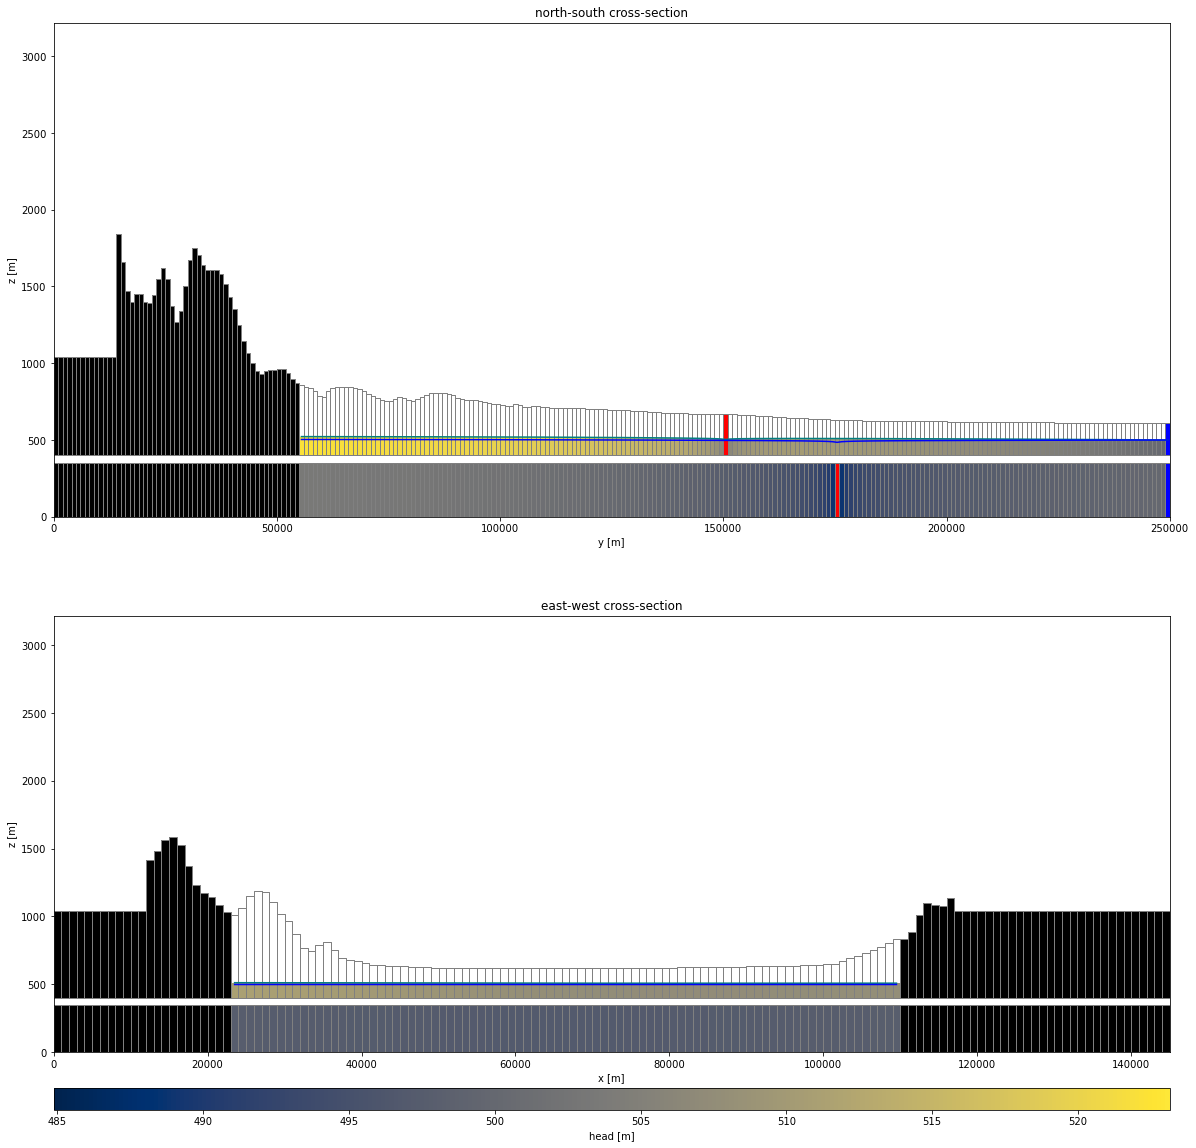

In [335]:
#Plot cross-section view of heads at center row and column:
row = 200   #row to plot cross-section along
col = 65   #column to plot cross-section along
lay = 0    #layer to plot heads from

f,ax = plt.subplots(2,1, figsize=(20,20))                                     #create empty figure and axes objects
xsec= flopy.plot.PlotCrossSection(model=mf, ax=ax[0], line={'column': col})  #plot cross-section along given column (change column # to see different locations)
h  = xsec.plot_array(head, masked_values=[-999.99], head=head, cmap='cividis', vmin=hmin,vmax=hmax)  #plot heads as an array, with color range set by min and max of full array
ax[0].plot(np.arange(delr/2,Ly,delr), head_mx[0,:,col], color='teal')                            #plots heads as a line
ax[0].plot(np.arange(delr/2,Ly,delr), head_mx[1,:,col], color='blue')                            #plots heads as a line
bc = xsec.plot_ibound()                                                      #plot boundary conditions
w = xsec.plot_bc("WEL", color='red')                           #plot wells
g  = xsec.plot_grid()                                                        #plot model grid
ax[0].set_xlabel('y [m]')
ax[0].set_ylabel('z [m]')
ax[0].set_title('north-south cross-section')

xsec= flopy.plot.PlotCrossSection(model=mf, ax=ax[1], line={'row': row})      #plot cross-ection along given row
h  = xsec.plot_array(head, masked_values=[-999.99], head=head, cmap='cividis', vmin=hmin,vmax=hmax)   #plot heads as array with same color range as above
bc = xsec.plot_ibound()                                                      #plot boundary conditions
ax[1].plot(np.arange(delc/2,Lx,delc), head_mx[0,row,:], color='teal')                            #plots heads as a line
ax[1].plot(np.arange(delc/2,Lx,delc), head_mx[1,row,:], color='blue')                            #plots heads as a line
g  = xsec.plot_grid()                                                        #plot grid
ax[1].set_xlabel('x [m]')
ax[1].set_ylabel('z [m]')
ax[1].set_title('east-west cross-section')

#Add colorbar:
divider = make_axes_locatable(ax[1])                     #make axes dividable (to add colorbar)
cax = divider.append_axes('bottom', size="5%", pad=0.5)   #add an axis at the bottom for the colorbar
c = plt.colorbar(h, cax=cax, orientation='horizontal')     #plot the colorbar
c.set_label('head [m]')                                  #label the colorbar